In [1]:
import copy
import random
import re

import numpy
import pandas


from hilbert.curves import Polynomial, Xlog, Log, InverseXPolynomial

from curve_fits import Call, Spec

from curve_fits import fits
from curve_fits import frames

In [2]:
def random_ints_sample(size, max_abs=10000):
    return random.sample(range(-max_abs, max_abs), k=size)

In [3]:
size_range = range(1050, 1750)
overfit = 1  # HIGH to differentiate from single-line shape
init_calls = [Call(random_ints_sample(size)) for size in size_range]
profile = frames.TimeComplexityProfile('set', init_calls, {'pop': Call(), 'copy': Call()},
    index=pandas.Index(size_range, name='List length'), overfit=overfit, fraction=0.9, loops=100)

In [4]:
profile.fit_all_with(
    Call(Spec(Polynomial, 2), Spec(Log, 1, pole=10), initial_params=[-1, 1, -1]),
    Call(Spec(Xlog, 1), Spec(InverseXPolynomial, 1)), piecewise=[
        Call([x], *[Call(Spec(Polynomial, 2))]*2) for x in range(1300, 1420)])

In [5]:
profile.best_fits(limit=3)

kind  \
key  cost                                
pop  0.008716  PW:Poly(1)[1359]Poly(1)   
     0.009327  PW:Poly(1)[1367]Poly(1)   
     0.009787  PW:Poly(1)[1369]Poly(1)   
copy 0.014159  PW:Poly(1)[1365]Poly(1)   
     0.014169  PW:Poly(1)[1366]Poly(1)   
     0.014447  PW:Poly(1)[1364]Poly(1)   

                                                             fit DOF  
key  cost                                                             
pop  0.008716  (-0.0075 ± 0.0026) + (0.0000511 ± 0.0000022)x ...   4  
     0.009327  (-0.0130 ± 0.0033) + (0.0000559 ± 0.0000027)x ...   4  
     0.009787  (-0.0136 ± 0.0035) + (0.0000564 ± 0.0000029)x ...   4  
copy 0.014159  (0.0053 ± 0.0022) + (0.0000626 ± 0.0000018)x |...   4  
     0.014169  (0.0015 ± 0.0028) + (0.0000658 ± 0.0000023)x |...   4  
     0.014447  (0.0047 ± 0.0023) + (0.0000631 ± 0.0000019)x |...   4

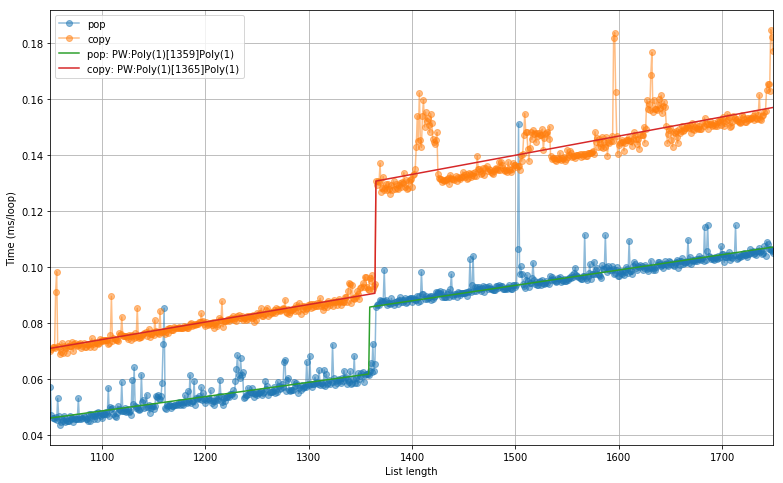

In [6]:
fig, ax = profile.plot(limit=1)

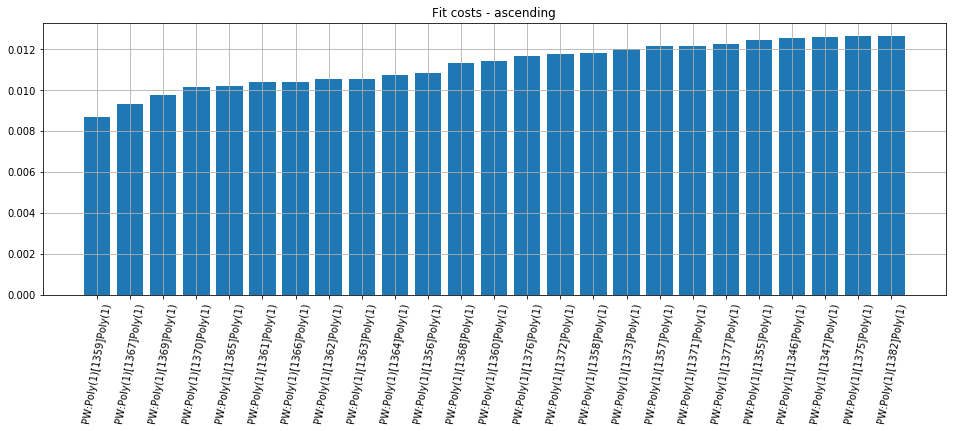

In [7]:
fig, ax = profile.plot_costs('pop', limit=25, rotation=80)

In [8]:
all_fits = profile.best_fits(limit=None)
all_fits[(all_fits.kind == 'Log+Poly(1)') | (all_fits.kind == 'Poly(-1)+Xlog')]

kind  \
key  cost                      
pop  0.019072  Poly(-1)+Xlog   
     0.019987    Log+Poly(1)   
copy 0.030725    Log+Poly(1)   
     0.030768  Poly(-1)+Xlog   

                                                             fit DOF  
key  cost                                                             
pop  0.019072      (0.000010271 ± 9.0E-8)xlogx + (-36.4 ± 1.3)/x   2  
     0.019987  (-0.83 ± 0.19) + (0.000015 ± 0.000022)x + (0.1...   3  
copy 0.030725  (-0.93 ± 0.29) + (0.000052 ± 0.000034)x + (0.1...   3  
     0.030768       (0.00001502 ± 1.4E-7)xlogx + (-51.0 ± 2.0)/x   2

In [9]:
pop_fit = profile.best_fit('pop')
pop_fit, pop_fit.curve

(<PiecewiseFit: (-0.0075 ± 0.0026) + (0.0000511 ± 0.0000022)x | (0.0111 ± 0.0024) + (0.0000549 ± 0.0000015)x>,
 <Vector: (-0.007547184629451818) + (5.106904902211493e-05)x | (0.01110462856026496) + (5.492334290028513e-05)x>)

In [10]:
pop_fit.fits, pop_fit.jumps_at

((<CurveFit: (-0.0075 ± 0.0026) + (0.0000511 ± 0.0000022)x>,
  <CurveFit: (0.0111 ± 0.0024) + (0.0000549 ± 0.0000015)x>),
 (1359,))

In [11]:
pop_fit.fits[1].measures

(<Measure: 0.0111 ± 0.0024>, <Measure: 0.0000549 ± 0.0000015>)

In [12]:
pop_fit_copy = copy.deepcopy(pop_fit)
pop_fit_copy.series = None   # Mocked to show equality is not affected
assert pop_fit == copy.deepcopy(pop_fit)

In [13]:
pop_fit_call = Call(pop_fit.jumps_at, *[Call(Spec(Polynomial, 2))]*2)
assert pop_fit != fits.PiecewiseFit(profile.data['pop'], pop_fit.space, *pop_fit_call.args, **pop_fit_call.kwargs)

In [14]:
assert [re.sub(r'\[[0-9]{3,}\]', '', kind) for kind in profile.best_fits(limit=1)['kind']] == [
    'PW:Poly(1)Poly(1)', 'PW:Poly(1)Poly(1)']